## ECCO - Melville Bay

### Export netcdfs for sequential rows

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
import glob

#### Create netCDFs for theta and salt

In [2]:
ecco_melville_theta_dir = Path('/Volumes/OMGNarwhals/PhD_chap3/data/ECCO_melville/W_Greenland/THETA/')
ecco_melville_salt_dir = Path('/Volumes/OMGNarwhals/PhD_chap3/data/ECCO_melville/W_Greenland/SALT/')

In [3]:
theta_files = list(ecco_melville_theta_dir.glob('*nc'))
salt_files = list(ecco_melville_salt_dir.glob('*nc'))

In [4]:
## theta
theta_ds = xr.open_mfdataset(theta_files,combine='nested',concat_dim='time',parallel=True,\
                            data_vars='all', coords='all')

In [87]:
## salt
salt_ds = xr.open_mfdataset(salt_files,combine='nested',concat_dim='time',parallel=True,\
                            data_vars='all', coords='all')

Look at size of each grid cell

In [6]:
## open geometry file
geometry = xr.open_dataset('SASSIE_N1_geometry_v3.nc')

In [7]:
geometry

<xarray.Dataset> Size: 2GB
Dimensions:  (j: 1080, i: 1440, k: 90)
Coordinates:
    XC       (j, i) float32 6MB ...
    YC       (j, i) float32 6MB ...
    Z        (k) float32 360B ...
    Zu       (k) float32 360B ...
    Zl       (k) float32 360B ...
Dimensions without coordinates: j, i, k
Data variables:
    hFacC    (k, j, i) float64 1GB ...
    maskC    (k, j, i) int64 1GB ...
    RAC      (j, i) float64 12MB ...
    dX       (j, i) float64 12MB ...
    drF      (k) float64 720B ...
Attributes:
    date_created:            2022-04-26T21:59:37
    date_modified:           2022-04-26T21:59:37
    date_metadata_modified:  2022-04-26T21:59:37
    date_issued:             2022-04-26T21:59:37

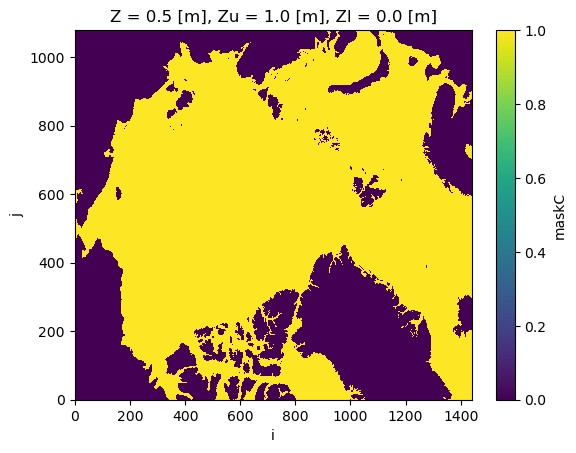

In [17]:
geometry.sel(k=0).maskC.plot()

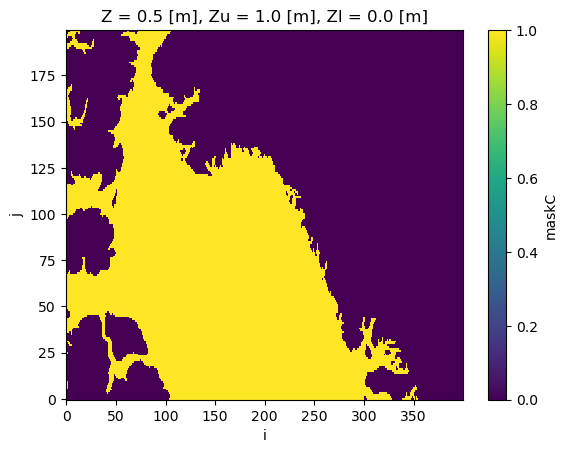

In [15]:
geometry.sel(j=slice(0,200),i=slice(700,1100)).sel(k=0).maskC.plot()

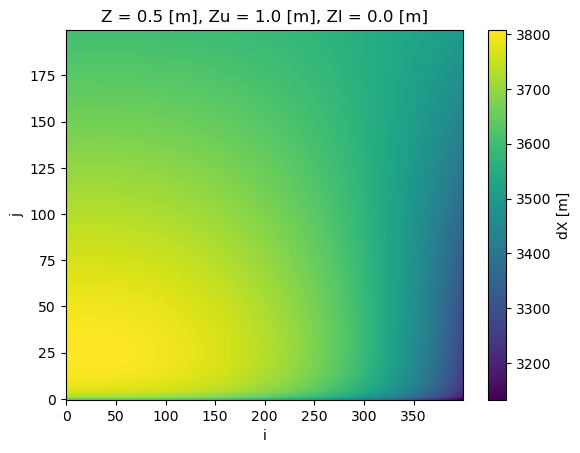

In [16]:
geometry.sel(j=slice(0,200),i=slice(700,1100)).sel(k=0).dX.plot()

Need to make a coordinate that combines year, month, and day

In [90]:
def create_time_dt64(ecco_ds):
    time_list = []
    for i in range(len(ecco_ds.time.values)):
        year  = ecco_ds.years.isel(time=i).values
        month = ecco_ds.months.isel(time=i).values
        day   = ecco_ds.days.isel(time=i).values
        
        if month<10 and day<10:
            time_tmp = str(year)+'-'+'0'+str(month)+'-'+'0'+str(day)
        elif month<10 and day>=10: 
            time_tmp = str(year)+'-'+'0'+str(month)+'-'+str(day)
        elif month>=10 and day<10: 
            time_tmp = str(year)+'-'+str(month)+'-'+'0'+str(day)
        else:
            time_tmp = str(year)+'-'+str(month)+'-'+str(day)
        
        time_list.append(time_tmp)
    
    time_dt64 = np.array(time_list, dtype='datetime64')
        
    return time_dt64

In [91]:
time_dt64 = create_time_dt64(theta_ds)

Add new time coordinate to dataset

In [92]:
theta_time_ds = theta_ds.assign_coords({"time":time_dt64})
salt_time_ds  = salt_ds.assign_coords({"time":time_dt64})

/var/folders/rm/8lkzq38j0d10h7pjtnd728_w0000gn/T/ipykernel_82534/1578866282.py:1: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  theta_time_ds = theta_ds.assign_coords({"time":time_dt64})
/var/folders/rm/8lkzq38j0d10h7pjtnd728_w0000gn/T/ipykernel_82534/1578866282.py:2: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64

Extract rows and export to individual netcdfs

In [15]:
import gsw

In [94]:
# convert to TEOS-10 standards

# PSU to g/kg
pressure = gsw.conversions.p_from_z(-salt_time_ds.depth, salt_time_ds.isel(time=0).latitude.mean().values)
salt_absolute_ds = gsw.conversions.SA_from_SP(salt_time_ds.SALT, pressure,\
                                              salt_time_ds.isel(time=0).longitude, salt_time_ds.isel(time=0).latitude)

In [96]:
print(salt_time_ds.SALT.isel(time=0,depth=0,rows=150,cols=50).values)
print(salt_absolute_ds.isel(time=0,depth=0,rows=150,cols=50).values)

32.91999
33.076021773051906


In [97]:
# replace SALT in dataset and update metadata
salt_time_ds.SALT.values = salt_absolute_ds
salt_time_ds.SALT.attrs['description'] = 'Absolute Salinity'

In [98]:
print(salt_time_ds.SALT.isel(time=0,depth=0,rows=150,cols=50).values)
print(salt_absolute_ds.isel(time=0,depth=0,rows=150,cols=50).values)

33.076021773051906
33.076021773051906


In [100]:
# in situ temp to conservative temp
theta_conservative_ds = gsw.conversions.CT_from_pt(salt_absolute_ds, theta_time_ds.THETA)

In [101]:
print(theta_time_ds.THETA.isel(time=0,depth=0,rows=150,cols=50).values)
print(theta_conservative_ds.isel(time=0,depth=0,rows=150,cols=50).values)

-1.781645
-1.7762309055341596


In [102]:
# replace THETA in dataset and update metadata
theta_time_ds.THETA.values = theta_conservative_ds
theta_time_ds.THETA.attrs['description'] = 'Conservative Temperature'

In [103]:
print(theta_time_ds.THETA.isel(time=0,depth=0,rows=150,cols=50).values)
print(theta_conservative_ds.isel(time=0,depth=0,rows=150,cols=50).values)

-1.7762309055341596
-1.7762309055341596


Save datasets

In [105]:
# theta_dir = 'F:/PhD_chap3/data/ECCO_melville/rows_netcdfs/THETA/'
theta_dir = '/Users/mariezahn/data/ECCO_WGreenland/rows_netcdfs_teos10/THETA/'

# salt_dir = 'F:/PhD_chap3/data/ECCO_melville/rows_netcdfs/SALT/'
salt_dir = '/Users/mariezahn/data/ECCO_WGreenland/rows_netcdfs_teos10/SALT/'

In [107]:
theta_time_ds.isel(rows=0).load().to_netcdf(theta_dir + 'W_Greenland_THETA_2015to2020_row000.nc')
print("row 0 complete\n")
theta_time_ds.isel(rows=25).load().to_netcdf(theta_dir + 'W_Greenland_THETA_2015to2020_row025.nc')
print("row 25 complete\n")
theta_time_ds.isel(rows=50).load().to_netcdf(theta_dir + 'W_Greenland_THETA_2015to2020_row050.nc')
print("row 50 complete\n")
theta_time_ds.isel(rows=75).load().to_netcdf(theta_dir + 'W_Greenland_THETA_2015to2020_row075.nc')
print("row 75 complete\n")
theta_time_ds.isel(rows=100).load().to_netcdf(theta_dir + 'W_Greenland_THETA_2015to2020_row100.nc')
print("row 100 complete\n")
theta_time_ds.isel(rows=125).load().to_netcdf(theta_dir + 'W_Greenland_THETA_2015to2020_row125.nc')
print("row 125 complete\n")
theta_time_ds.isel(rows=150).load().to_netcdf(theta_dir + 'W_Greenland_THETA_2015to2020_row150.nc')
print("row 150 complete\n")

row 0 complete

row 25 complete

row 50 complete

row 75 complete

row 100 complete

row 125 complete

row 150 complete



In [108]:
salt_time_ds.isel(rows=0).load().to_netcdf(salt_dir + 'W_Greenland_SALT_2015to2020_row000.nc')
print("row 0 complete\n")
salt_time_ds.isel(rows=25).load().to_netcdf(salt_dir + 'W_Greenland_SALT_2015to2020_row025.nc')
print("row 25 complete\n")
salt_time_ds.isel(rows=50).load().to_netcdf(salt_dir + 'W_Greenland_SALT_2015to2020_row050.nc')
print("row 50 complete\n")
salt_time_ds.isel(rows=75).load().to_netcdf(salt_dir + 'W_Greenland_SALT_2015to2020_row075.nc')
print("row 75 complete\n")
salt_time_ds.isel(rows=100).load().to_netcdf(salt_dir + 'W_Greenland_SALT_2015to2020_row100.nc')
print("row 100 complete\n")
salt_time_ds.isel(rows=125).load().to_netcdf(salt_dir + 'W_Greenland_SALT_2015to2020_row125.nc')
print("row 125 complete\n")
salt_time_ds.isel(rows=150).load().to_netcdf(salt_dir + 'W_Greenland_SALT_2015to2020_row150.nc')
print("row 150 complete\n")

row 0 complete

row 25 complete

row 50 complete

row 75 complete

row 100 complete

row 125 complete

row 150 complete



Extract data from a point close to the APEX float profiles

In [9]:
# see where the float was predominantly located
apex_dir = Path('F:/PhD_chap3/data/OMG_Float_data/OMG_APEX_Float_Data/APEX')
F9444_data_ds = xr.open_dataset(apex_dir / 'F9444/APEX_F9444_profiles_binned.nc')

In [13]:
F9444_data_ds.lat.mean().values

array(75.57451882)

In [14]:
F9444_data_ds.lon.mean().values

array(-62.35893467)

In [18]:
tmp = theta_time_ds.isel(time=0,depth=0).load()

In [ ]:
# the kong oscar mooring was located at 75.8 N -59.8 E
tmp.isel(cols=110,rows=172)

In [39]:
# APEX float
theta_time_ds.isel(cols=110,rows=172).load().to_netcdf(theta_dir + 'W_Greenland_THETA_2015to2020_APEX_location.nc')
salt_time_ds.isel(cols=110,rows=172).load().to_netcdf(salt_dir + 'W_Greenland_SALT_2015to2020_APEX_location.nc')

In [16]:
# loop to export separate netcdfs for each selected row (every 25 rows from 0 to 150)
rows_indices = np.arange(0,175,25)

for i in range(len(rows_indices)):
    filename = 'W_Greenland_THETA_2015to2018_row' + str(rows_indices[i]) + '.nc'
    theta_select = theta_time_ds.isel(rows=i)
    theta_select.load().to_netcdf('H:/PhD_chap3/data/ECCO_melville/rows_netcdfs/THETA/' + filename)
    theta_select.close()

In [17]:
rows_indices = np.arange(0,175,25)
for i in range(len(rows_indices)):
    filename = 'W_Greenland_SALT_2015to2018_row' + str(rows_indices[i]) + '.nc'
    salt_select = salt_time_ds.isel(rows=i)
    salt_select.load().to_netcdf('H:/PhD_chap3/data/ECCO_melville/rows_netcdfs/SALT/' + filename)
    salt_select.close()

Look at a dataset

In [15]:
tmp = xr.open_dataset("H:/PhD_chap3/data/ECCO_melville/rows_netcdfs/THETA/W_Greenland_THETA_2015to2018_row150.nc")

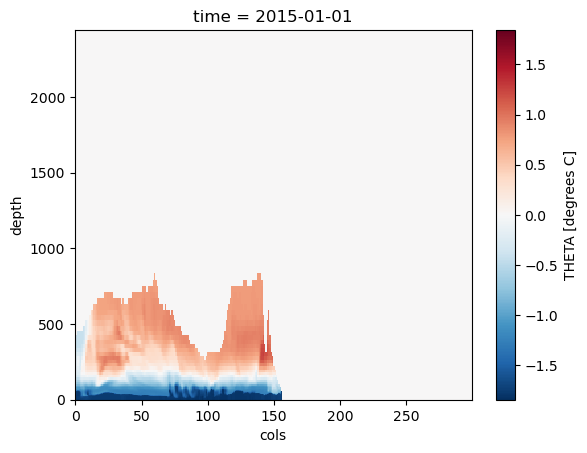

In [17]:
tmp.isel(time=0).THETA.plot()